# Saving and Loading Models

In this notebook, I'll show you how to save and load models with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

First off, I'll implement my own feedforward network for the exercise you worked on in part 4 using the Fashion-MNIST dataset. This will serve as a solution for part 4, as well as an example I'll use to show you how to save and load models.

As usually, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part.

In [1]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here we can see one of the images.

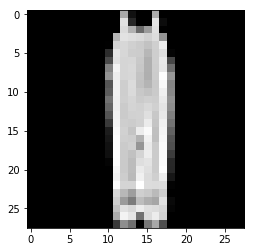

In [2]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

With the data loaded, it's time to import the necessary packages.

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

## Building the network

As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. I used `nn.ModuleList` to allow for an abritrary number of hidden layers. This model has an argument `hidden_layers` that's a list of the hidden layer sizes (as integers). Using `nn.ModuleList` registers each hidden layer module properly so you can use module methods in the model.

I also have the `forward` method returning the log-softmax for the output. Since softmax is a probability distibution over the classes, the log-softmax is a log probability which comes with a [lot of benefits](https://en.wikipedia.org/wiki/Log_probability). Using the log, computations are often faster and more accurate. To get the class probabilities later, I'll need to take the exponential (`torch.exp`).

In [47]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

# Train the network


Since the model's forward method returns the log-softmax, I use the [negative log loss](http://pytorch.org/docs/master/nn.html#nllloss) as my criterion, `nn.NLLLoss()`. I also chose to use the [Adam optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Adam). This is a variant of stochastic gradient descent which includes momentum and in general trains much faster than vanilla SGD.

Otherwise, the training code is the same as you've seen before.

In [48]:
# Create the network, define the criterion and optimizer
model = Network(784, 10, [500, 100])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
epochs = 2
steps = 0
running_loss = 0
print_every = 10
for e in range(epochs):
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        # Wrap images and labels in Variables so we can calculate gradients
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = model.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(testloader):
                
                images = images.resize_(images.size()[0], 784)
                inputs = Variable(images, volatile=True)
                
                predicted = torch.exp(model.forward(inputs).data)
                equality = (labels == predicted.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Test accuracy: {:.4f}".format(accuracy/(ii+1)))
            running_loss = 0

Epoch: 1/2 Loss: 1.7408 Test accuracy: 0.6423
Epoch: 1/2 Loss: 0.9796 Test accuracy: 0.6849
Epoch: 1/2 Loss: 0.6701 Test accuracy: 0.7298
Epoch: 1/2 Loss: 0.6914 Test accuracy: 0.7391
Epoch: 1/2 Loss: 0.6576 Test accuracy: 0.7461
Epoch: 1/2 Loss: 0.6269 Test accuracy: 0.7435
Epoch: 1/2 Loss: 0.6187 Test accuracy: 0.7675
Epoch: 1/2 Loss: 0.6374 Test accuracy: 0.7659
Epoch: 1/2 Loss: 0.6175 Test accuracy: 0.7680
Epoch: 1/2 Loss: 0.5515 Test accuracy: 0.7822
Epoch: 1/2 Loss: 0.5092 Test accuracy: 0.7852
Epoch: 1/2 Loss: 0.5431 Test accuracy: 0.7983
Epoch: 1/2 Loss: 0.5631 Test accuracy: 0.8000
Epoch: 1/2 Loss: 0.5246 Test accuracy: 0.7894
Epoch: 1/2 Loss: 0.5936 Test accuracy: 0.7846
Epoch: 1/2 Loss: 0.6009 Test accuracy: 0.7911
Epoch: 1/2 Loss: 0.5236 Test accuracy: 0.8045
Epoch: 1/2 Loss: 0.5418 Test accuracy: 0.8025
Epoch: 1/2 Loss: 0.5130 Test accuracy: 0.8040
Epoch: 1/2 Loss: 0.5019 Test accuracy: 0.8030
Epoch: 1/2 Loss: 0.4901 Test accuracy: 0.8016
Epoch: 1/2 Loss: 0.5432 Test accur

Epoch: 2/2 Loss: 0.3904 Test accuracy: 0.8672
Epoch: 2/2 Loss: 0.3896 Test accuracy: 0.8614
Epoch: 2/2 Loss: 0.3597 Test accuracy: 0.8544
Epoch: 2/2 Loss: 0.3459 Test accuracy: 0.8638
Epoch: 2/2 Loss: 0.3430 Test accuracy: 0.8632
Epoch: 2/2 Loss: 0.3599 Test accuracy: 0.8543
Epoch: 2/2 Loss: 0.3562 Test accuracy: 0.8617
Epoch: 2/2 Loss: 0.3281 Test accuracy: 0.8646


## Saving and loading networks

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

In [46]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our network: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=500)
    (1): Linear(in_features=500, out_features=100)
  )
  (output): Linear(in_features=100, out_features=10)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'output.weight', 'output.bias'])


The simplest thing to do is simply save the state dick with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [47]:
torch.save(model.state_dict(), 'checkpoint.pth')

Then we can load the state dict with `torch.load`.

In [13]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'output.weight', 'output.bias'])


And to load the state dict in to the network, you do `model.load_state_dict(state_dict)'`.

In [24]:
model.load_state_dict(state_dict)

Seems pretty straightforward, but as usual it's a bit more complicated. Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. If I create a model with a different architecture, this fails.

In [18]:
# Try this
net = Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
net.load_state_dict(state_dict)

RuntimeError: While copying the parameter named hidden_layers.0.weight, whose dimensions in the model are torch.Size([400, 784]) and whose dimensions in the checkpoint are torch.Size([500, 784]).

This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be saved in the checkpoint, along with the state dict. To do this, you build a dictionary with all the information you need to compeletely rebuild the model.

In [37]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Now the checkpoint has all the necessary information to rebuild the trained model. You can easily make that a function if you want. Similarly, we can write a function to load checkpoints. 

In [42]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                    checkpoint['output_size'],
                    checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [50]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=500)
    (1): Linear(in_features=500, out_features=100)
  )
  (output): Linear(in_features=100, out_features=10)
)
